\title{HP 34401 Controlled with Python via RS-232 without VISA}
\author{Steven K Armour}
\maketitle

The goal of this program/notebook is to develop a program that can control and log a circa ~1990 Benchtop/Rack multimeter from  HP(Agilent) without the need for any sort of VISA library. While a VISA library and subsequent based program (see `pyvisa` for ex) is convenient the goal of this code is to show that it is not necessary. And while the code developed hereand while as `pyvisa-py`  can be used with a raspberry pi there are two inconveniences with using VISA.
1. The instruments commands  must be in the VISA database that is being used wich is not always the case
2. with  `pyvisa-py` VISA can be used on linux computers. But with direct command programing an instrument can (in theory) interact with the `MicroPython` microcontroller platform 

While this code can not be run as is on `MiroPython` is could be with some refactoring

Needed hardware:
+ HP or Agilent 34401 Multimeter
+ USB to db9 RS-232 converter or a USB to db9 Null Modem RS-232 converter
+ RS-232 Null Modem if a dedicated USP to RS-232 Null Modem is not used

# Libraries used

In [1]:
import serial
import pandas as pd
import numpy as np
import xarray as xr
import threading
import matplotlib.pyplot as plt

import serial #implements rs-232 com
import pandas as pd # data collection
import numpy as np
import threading #used for mutlti threading
import matplotlib.pyplot as plt


# Setting up the rs-232 communication ports
+ for a windows machine go to device manager setting and determine what com port the usb to rs-232 cable is connected to

+ for a mac machine: ????????

+ for a linux ubuntu machine open a terminal and review the the list of connections to the computer via typing in the terminal
```ls -l  /dev/tty*```
at the end list one should see ```/dev/ttyUSB``` with an ending number of the USB port. After selecting the appropriate port one will typically need to unlock the port via 
``` sudo chmod 666  /dev/ttyUSB```

In [2]:
UnLockedPort='/dev/ttyUSB0'

# Program

In [4]:
class MultiMeter34401A():
    """
    Class to initiate a conenction/control/record a HP multimeter from python
    without VISA
    
    The recorded values and recorded errors are stored in the following
    dataframes:
        self.Errors
        self.Data
    """
    def __init__(self, Name):
         """ 
        Initiate some helpers and the data storage dataframes
        
        Args:
            Name (str): a convenient name of the mass flow controller
            
        """
        self.Name=Name
        
        #Dataframe to store errors
        self.Errors=pd.DataFrame(columns=['Last Command', 'Time', 'Error'])
        #Dataframe to store recordings
        self.Data=pd.DataFrame(columns=['Time', 'Value', 'Mode'])
    
    def MakeConnection(self, ULSerPort):
        """
        Method to startup the rs-232 serial connection via the python
        serial library
        
        Args:
            ULSerPort (str)
        
        """
        #model number as a check of correct connection
        MODEL='34401A'
        try:
            self.MMSer=serial.Serial(ULSerPort, 9600, timeout=1) 
            self.MMSer.write(b'*IDN?\n')
            self.IDN=self.MMSer.readline().decode("utf-8")[:-2]
        except Exception as ex:
            print(ex)
        
        if self.IDN.find(MODEL)==-1:
            raise ValueError(f'{self.IDN} not supported by this class ony supports {MODEL}')
            
        
    def RemoteSetup(self):
        """
        Method to run a command sequence to put the instrument into remote
        mode. The Mutltimeter can be taken of remote by pressing shift on the
        contorls; but can be brought back to remote mode by rerunning this
        method
        """
        #command   ; exspected response
        #Reset
        C1=b'*RST\n'; GR1=5
        #Clear
        C2=b'*CLS\n'; GR2=5
        C3=b'*ESE 1\n'; GR3=7
        C4=b'*SRE 32\n'; GR4=8
        #Go to remote mode
        C5=b'SYST:REM\n'; GR5=9
        #Vain attempt to turn off the beeper 
        C6=b'SYST:BEEP:STAT OFF\n'; GR6=19
        
        ComandSeq=[C1, C2, C3, C4, C5, C6]
        ResponceSeq=[GR1, GR2, GR3, GR4, GR5, GR6]
        
        #run the command sequence and verify it went oky
        for Comd, Res in zip(ComandSeq, ResponceSeq):
            if self.MMSer.write(Comd)==Res:
                pass
            else:
                raise ValueError(f'Remote Setup Error on command {Comd} ')
                break
        print('Remote Connection Made')
        self.Mode='DC_V'
        
    def ModeSet(self, Mode='DC_V'):
        """
        Method to set the measurement mode of the 34401A using shorthand
        
        Args:
            Mode (str; Def. 'DC_V): Sets the mode of 34401A the available
            modes are: 
            
           'DC_V': DC Voltage Reading,
           'DC_I': DC Current Reading,
           'AC_V': AC Voltage Reading,
           'AC_I': AC Current Reading,
           'Res2W': 2 Wire Resistance Reading,
           'Res4W': 4 Wire Resistance Reading,
           'Freq': AC Main Frequency Measurement,
           'Period':AC Main Period Measurement
        """
        C={'DC_V':b'CONF:VOLT:DC\n',
           'DC_I':b'CONF:CURR:DC\n',
           'AC_V':b'CONF:VOLT:AC\n',
           'AC_I':b'CONF:CURR:AC\n',
           'Res2W':b'CONF:RES\n',
           'Res4W':b'CONF:FRES\n',
           'Freq':b'CONF:FREQ\n',
           'Period':b'CONF:PER\n'}
        try:
            self.MMSer.write(C[Mode])
            self.Mode=Mode
        except KeyError:
            print(f'Mode {Mode} is not a meassurment mode of this insturment')
        
    
        
    def ErrorReadAct(self):
        """
        Method to read the Error from the 34401A and record the errors. Also
        clears the `-410,"Query INTERRUPTED"` that occurs because of the 
        slow reading to output transfer compared to the speed of modern
        computers 
        
        Return:
            returns the non 410 error if non 410 error occurs

        """
        #ask for the error
        if self.MMSer.write(b'SYST:ERR?\n')!=10:
            raise ValueError('Error State Not Readable!!!')
        
        #read the error 
        ErrRes=self.MMSer.readline().decode("utf-8")[:-2]
        if ErrRes=='+0,"No error"':
            return None
        
        # the called before ready error that is ignored and cleared
        elif ErrRes=='-410,"Query INTERRUPTED"':
            #clear the buffer and ignore
            self.MMSer.write(b'*CLS\n')
        
        # for any other errors record them
        else:
            #'Last Command', 'Time', 'Error'
            self.Errors.loc[self.Errors.shape[0],:]=['', pd.Timestamp.now(), ErrRes]
            try:
                self.EndAutoRun()
            except:
                pass
            
        return ErrRes
    
    def QurreyProgress(self, debug=False):
        """
        Method to cheack the progress of getting the reading to the output
        register on the RS-232 line using repetitive calls to the SCPI OPC
        routine
        
        Arg:
            debug (bool; Def. False): if True prints out if the Query is
            still in progress transferring to the RS-232 output register
            
        Return:
            1 if the information is ready on the RS-232 register
            
            If the call counter is triggered a error is raised and if the 
            Autorun is ongoing will be stopped
            
        """
        #counter to act like a time out
        Counter=0
        while True:
            #ask for the OPC
            if self.MMSer.write(b'*OPC?\n')==6:
                pass
            else:
                raise ValueError('Operation Complet Command Not Excepted!!!')
            
            #if complet return  1
            CompState=self.MMSer.readline().decode("utf-8")[:-2]
            if CompState=='':
                if debug:
                    print('Qurrey in Prog')
                pass
            elif CompState=='1':
                if debug:
                    print('Qurry Complet')
                break
            else:
                break
                return CompState
                
            
            # The Time out action that if triggered will cancel the autorun
            Counter+=1
            if Counter==10:
                raise ValueError('Operation is not Completing after 10 cyles!!!')
                try:
                    self.EndAutoRun()
                except:
                    pass
                break
        
    
    def MakeMeasurment(self):
        """
        Method to make a measurement on the 34401A usign the 
        SCPI INIT OPC FETCH method where the OPC is done via 
        `self.QurreyProgress` If the reading is successful then the reading
        is recorded to `self.Data` 
        """
        #accurire the reading on the 34401A
        if self.MMSer.write(b'INIT\n')==5:
            pass
        else:
            raise ValueError('Get Mesurment Comand Not Taken!!!')
        
        #perform the OPC ready check
        self.QurreyProgress()
        
        # Read the value from the 34401A
        if self.MMSer.write(b'FETCH?\n')==7:
            pass
        else:
            raise ValueError('Fetch Measurment Comand Not Taken!')
        
        
        M=self.MMSer.readline(); T=pd.Timestamp.now()
        try:
            M=float(M.decode("utf-8")[:-2])
            #'time', 'value', 'Mode'
            self.Data.loc[self.Data.shape[0], :]=[T, M, self.Mode]
        except Exception as ex:
            print(ex)
            self.ErrorReadAct()
        
        self.ErrorReadAct()
        
    def SetupLivePlot(self):
        """
        Internal Method for creating the fig, ax for live ploting
        """
        %matplotlib notebook
        %matplotlib notebook

        self.fig, self.ax=plt.subplots(nrows=1, ncols=1)

        
    def LivePlotData(self):
        """
        Method that performance the live ploting of the data from the 
        instrument
        """
        
        # if the everything is setup run this
        try:
            self.ax.clear()
            # plot the values recorded in self.Data where the Mode
            #of the recorded data equals the current mode of the multimeter
            # TODO could be made into subplots for each mode
            # TODO should have splits in mode reflect in graph
            self.Data.where(self.Data['Mode']==self.Mo15de).plot(x='Time', y='Value', 
                                                               title=self.Mode, ax=self.ax, legend=False)
            self.fig.canvas.draw()
        # if everything is not setup perform the setup and rerun
        except AttributeError:
            self.SetupLivePlot()
            self.LivePlotData()
    
    def RunAction(self):
        """
        Method for the actions that should happen during a autorun event
        """
        self.MakeMeasurment()
        self.LivePlotData()
    
    def AutoRun(self, IntervalStep=10, IntervalUnit='Min', ReGenPlot=False):
        """
        Exsternal Method called by the user to initiate auto running of the 
        the instrument on a separate thread so that python can continue to
        perform  more task
        
        Args:
            IntervalStep (int): the interval time inverval that the autorun's
            actions are done 
            
            IntervalUnit (str; Default 'Min' {Hour, Sec}): the unit of the 
            intervals auto running 
            exsample IntervalStep=10, IntervalUnit='Min' will perform the 
            autorun action every 10 minutes
            
            ReGenPlot (bool; Default False): True will create a new instance 
            of the live plot where as False will reuse the old live plot
        """
            #recreate the plot in a new instance of plot

            if ReGenPlot:
                self.SetupLivePlot()
            # convert timer to sec
            InvertvalUnits={'Hour':60.0**2, 'Min':60.0, 'Sec':1.0}
            self.IntervalStep=float(IntervalStep*InvertvalUnits[IntervalUnit])
            #call the internal method to do instantiate the autorunning
            self.AutoRunRun()
    
    def AutoRunRun(self):
        """
        Internal Method to initiate the thread 
        
        Note:
            This method may be redundant but worked, will most likely will
            be removed in future. But for now this gets the thread  working 
            due to the seemingly recursive nature of the pythons thread
        
        """
        #call the run action
        self.RunAction()
        #create a thread timer and bind this method to the thread
        self.t=threading.Timer(self.IntervalStep, self.AutoRunRun)
        #start the thread
        self.t.start()
    
    def EndAutoRun(self):
        """
        Method to end the autorun via termination of the thread timer and
        joining the thread with bundle 
        """
        # terminate the timmer
        self.t.cancel()
        # terminate the thread and rejoin it to main bundle
        self.t.join()
        self.LivePlotData()
        
        
        
        
    
        
    
        
        
        
        
            

# Testing
The testing was done with the the front voltage/2W resistor directly connected to the outputs of a generic  benchtop DC Power supply while make will go unsaid for for very good reasons. As there was no load in the circuit the current function was not tested here but has been tested in additional test.

In [25]:
Meter1=MultiMeter34401A('MM1')
Meter1.MakeConnection(UnLockedPort)

In [26]:
Meter1.RemoteSetup()

Remote Connection Made


In [27]:
R=Meter1.ErrorReadAct(); print(R)

None


In [29]:
print(Meter1.Mode)
Meter1.ModeSet('DC_V')
print(Meter1.Mode)

AC_V
DC_V


In [30]:
Meter1.QurreyProgress(debug=True)

Qurry Complet


In [31]:
Meter1.MakeMeasurment()

In [32]:
Meter1.Errors

,Last Command,Time,Error


In [33]:
Meter1.Data

,Time,Value,Mode
0,2018-03-14 17:24:23.889505,3.55007,DC_V


<IPython.core.display.Javascript object>


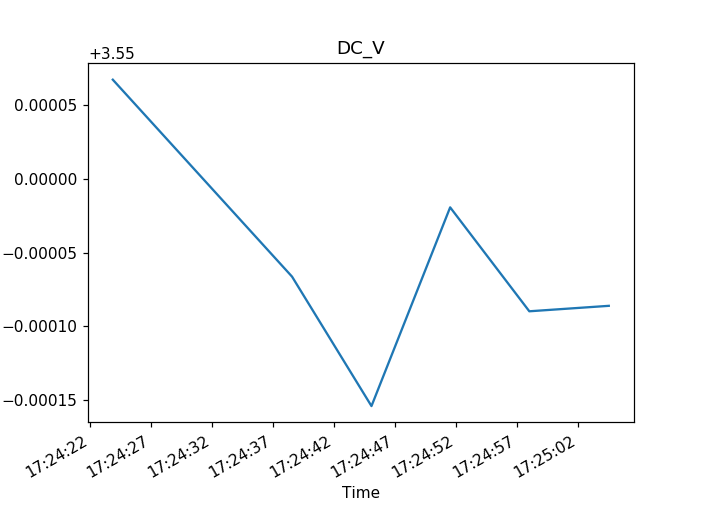

In [34]:
Meter1.AutoRun(5, 'Sec')

In [13]:
Meter1.ModeSet('Res4W')

In [35]:
Meter1.EndAutoRun()

In [14]:
Meter1.ModeSet('DC_V')

<IPython.core.display.Javascript object>


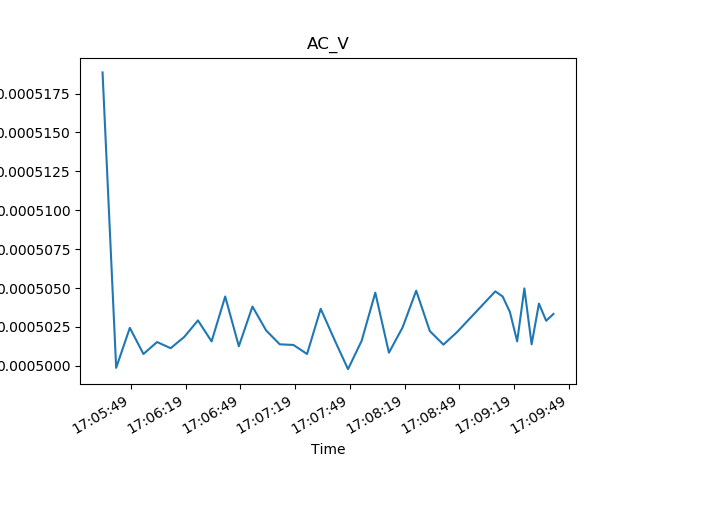

ValueError: Operation is not Completing after 10 cyles!!!

In [18]:
Meter1.AutoRun(1.5, 'Sec', ReGenPlot=True)

In [65]:
Meter1.EndAutoRun()

In [24]:
Meter1.Data

,Time,Value,Mode
0,2018-03-14 17:03:39.238313,3.55092,DC_V
1,2018-03-14 17:03:48.706383,3.55104,DC_V
2,2018-03-14 17:03:55.560135,3.55095,DC_V
3,2018-03-14 17:04:02.059870,3.55094,DC_V
4,2018-03-14 17:04:08.502715,3.55085,DC_V
5,2018-03-14 17:04:14.955578,3.55076,DC_V
6,2018-03-14 17:04:21.409643,3.55072,DC_V
7,2018-03-14 17:04:27.865159,3.55074,DC_V
8,2018-03-14 17:04:34.317043,3.55068,DC_V
9,2018-03-14 17:04:40.767884,3.55072,DC_V
